In [1]:
# 다운로드하지 않고 커스텀 pytorchcv.py 파일 사용.
# !wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py 

%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
import random

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128, seed=10) # load_mnist(batch_size, seed) 60000개의 train 데이터셋 중, 무작위로 50000개와 10000개로 분리하여 각각 train, test 데이터셋으로 활용합니다. 재현성을 보장하지 위해서 seed를 통해 무작위성을 통제합니다.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 데이터셋이 어떻게 구성되어 있는지를 확인
원본 데이터셋은 train 60000개, test 10000개로 구성되어 있지만, pytorchcv.py에서 데이터셋을 DataLoader에 로드하는 과정에서 train 데이터셋에서 10000개를 무작위로 선택해 valid 데이터셋으로 분할했습니다.

따라서 Train 50000, Valid 10000, Test 10000개로 구성된 것을 확인할 수 있습니다. Train : Valid : Test는 약 71.4 : 14.3 : 14.3의 비율을 가집니다.

각 데이터셋별 클래스의 개수를 확인해 본 결과, 모든 클래스의 데이터 개수가 비슷하게 분포된 것을 확인할 수 있습니다.

In [2]:
# 각 데이터셋별 총 데이터 개수. 
print("train =", len(data_train), "/", "Valid =", len(data_valid), "/", "Test =", len(data_test))

# Train 데이터셋의 클래스별 개수 확인
train_class_counts = {}
for idx in data_train.indices:
    target = data_train.dataset.targets[idx]
    train_class_counts[target.item()] = train_class_counts.get(target.item(), 0) + 1
    
# Valid 데이터셋의 클래스별 개수 확인
valid_class_counts = {}
for idx in data_valid.indices:
    target = data_valid.dataset.targets[idx]
    valid_class_counts[target.item()] = valid_class_counts.get(target.item(), 0) + 1

# Test 데이터셋의 클래스별 개수 확인
test_class_counts = {}
for target in data_test.targets:
    test_class_counts[target.item()] = test_class_counts.get(target.item(), 0) + 1

# 클래스의 순서대로 정렬하여 출력.
print("Train 데이터셋 클래스별 개수:", sorted(train_class_counts.items()))
print("Valid 데이터셋 클래스별 개수:", sorted(valid_class_counts.items()))
print("Test 데이터셋 클래스별 개수:", sorted(test_class_counts.items()))

train = 50000 / Valid = 10000 / Test = 10000
Train 데이터셋 클래스별 개수: [(0, 4980), (1, 4994), (2, 4996), (3, 5021), (4, 5027), (5, 5036), (6, 5037), (7, 4950), (8, 4974), (9, 4985)]
Valid 데이터셋 클래스별 개수: [(0, 1020), (1, 1006), (2, 1004), (3, 979), (4, 973), (5, 964), (6, 963), (7, 1050), (8, 1026), (9, 1015)]
Test 데이터셋 클래스별 개수: [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


클래스명을 확인해 본 결과 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'의 총 10개의 클래스가 존재하고. 이를 형태별로 묶어보았습니다.

상의 - T-shirt/top, Pullover, Dress, Coat, Shirt

하의 - Trouser

신발 - Sandal, Sandal, Ankle boot

가방 - Bag


이미지를 분류할 때, 비슷한 형태를 가진 클래스가 많을 수록 이미지가 잘못 분류될 확률이 높다고 생각하였고. 반대로 "하의"나 "가방"과 같이 비슷한 형태를 가진 클래스가 적을 수록 이미지가 올바르게 분류될 것이라고 예상하였습니다.

In [3]:
print(data_test.classes) # 데이터셋의 클래스명을 모두 출력

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


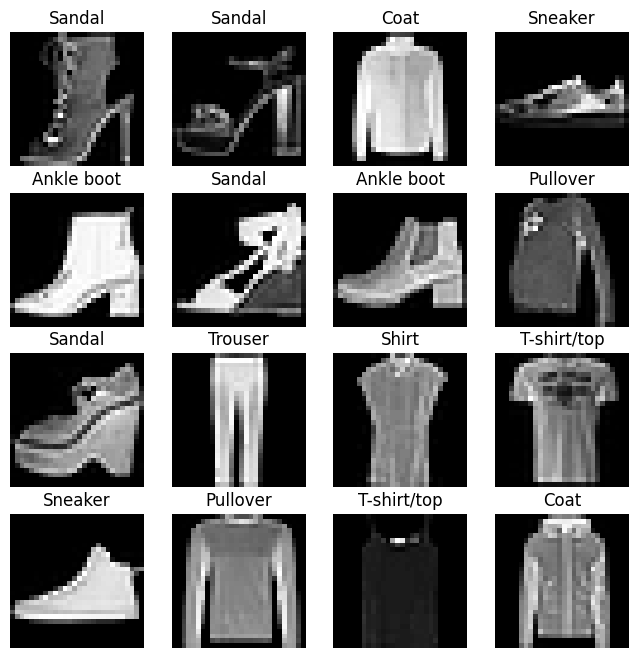

In [4]:
# 데이터셋이 어떻게 구성되어 있는지를 확인.

figure = plt.figure(figsize=(8, 8)) # 이미지 출력을 위한 전체 figure 크기 조정
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data_test), size=(1,)).item() # test 데이터셋에서 index를 랜덤하게 선택.
    img, label = data_test[sample_idx] # test 데이터에서 sample_idx에 해당하는 이미지와 label을 저장.
    figure.add_subplot(rows, cols, i) # rows와 cols값에 따라 이미지를 배치.
    plt.title(data_test.classes[label]) # 각 이미지의 타이틀을 클래스명으로 지정.
    plt.axis("off") # 이미지만을 표시하기 위해 좌표축과 선을 출력하지 않게 설정.
    plt.imshow(img.squeeze(), cmap="gray") # 그레이스케일로 이미지 출력.
plt.show()

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits.

The vertical edge filter emphasizes changes in intensity that occur vertically across the image, making it useful for detecting vertical lines and edges.

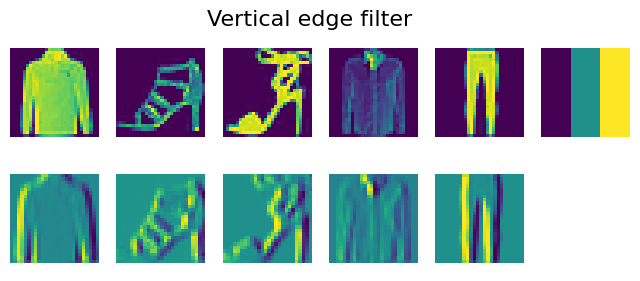

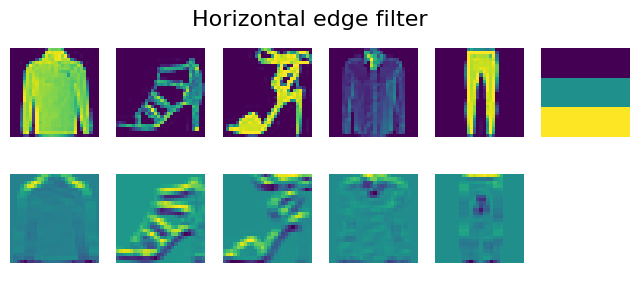

In [5]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

## Covolutional layers

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1.
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

The Rectified Linear Unit (ReLU) activation function is one of the most commonly used activation functions in neural networks, especially in deep learning models. The function is defined mathematically as:

ReLU(x)=max(0,x)

Here’s what this means:

If x is greater than 0, the function returns x.
If x is less than or equal to 0, the function returns 0.

Properties of ReLU
Non-linear: While it looks like a linear function, ReLU introduces a non-linearity (a simple threshold at 0), which allows models to learn more complex patterns.
Computationally Efficient: It is very efficient to compute as it only requires checking if the input is positive or not.
Sparse Activation: In practice, ReLU results in sparse activations; i.e., only a subset of neurons in a layer are active at a given time.

In [6]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

In [7]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, val_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, Valid 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval() # 평가 모드로 변경. 학습 x 
            val_loss, val_correct, val_total = 0, 0, 0 # valid로 변경
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    val_correct += (predicted == target).sum().item()
            
            val_loss /= len(val_loader.dataset)
            val_acc = 100. * val_correct / val_total
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



In [8]:
# Pytorch를 사용하여 학습된 모델을 평가하는 과정 구현.

def test(model, test_loader): # 함수를 정의하여 모델, Test 데이터 로더를 매개변수로 받음.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'test_loss': [], 'test_acc': []}

    try:
        model.eval()  # 모델을 평가 모드로 설정.

        test_loss, test_correct, test_total = 0, 0, 0 # 손실, 정답 수, 전체 데이터 수
        misclassified_images = [] # 이미지가 잘못 분류된 경우를 저장.
        misclassified_classes = {} # 잘못 분류된 클래스들의 빈도를 저장.

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data) # 모델을 통해 예측 수행.

                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                test_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output, 1) # 예측된 클래스를 가져옴.
                test_total += target.size(0) # 전체 데이터 수를 업데이트.
                test_correct += (predicted == target).sum().item() # 정확하게 예측된 데이터의 개수를 업데이트

                for i in range(len(predicted)): # 이미지를 예측한 수만큼 반복.
                    if predicted[i] != target[i]: # 잘못 분류된 이미지인 경우.
                        misclassified_images.append((data[i], predicted[i], target[i])) # 잘못 분류된 이미지를 리스트에 저장.
                        misclassified_class = int(target[i]) # 잘못 분류된 label을 분류
                        
                        if misclassified_class in misclassified_classes:
                            misclassified_classes[misclassified_class] += 1
                        else:
                            misclassified_classes[misclassified_class] = 1

        test_acc = 100. * test_correct / test_total # test 데이터셋의 정확도 계산.
        test_loss /= len(test_loader.dataset) # test 데이터셋의 loss 계산.
        print("-------------------------------------------------------")
        print(f'모델의 성능 평가: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')



        # 빈도 수가 높은 순서대로 정렬하여 출력
        sorted_classes = sorted(misclassified_classes.items(), key=lambda x: x[1], reverse=True) # 클래스 순서대로 정렬.
        
        print("-------------------------------------------------------")
        print("잘못 분류된 클래스들의 빈도:")
        for cls, freq in sorted_classes:
            print(f"{data_test.classes[cls]}: {freq} 개") 
        

        # 막대 그래프로 잘못 분류된 클래스들의 빈도 출력.
        sorted_classes = sorted(misclassified_classes.items(), key=lambda x: x[1], reverse=True) # 빈도수를 기준으로 내림차순으로 정렬.
        classes = [cls for cls, _ in sorted_classes] # sorted_classes에서 클래스만 추출.
        frequencies = [freq for _, freq in sorted_classes] # sorted_classes에서 빈도수만 추출. 

        class_list = [data_test.classes[cls] for cls in classes] # 0~9의 값으로 이루어진 클래스를 텍스트로 변경.

        # 잘못 분류된 이미지의 빈도수를 막대 그래프로 출력.
        plt.figure(figsize=(10, 5))
        plt.bar(class_list, frequencies, color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.title('Misclassified Classes Frequencies')
        plt.xticks(rotation=45, ha='right')
        plt.show()
        

        # 잘못 분류된 이미지 출력
        plt.figure(figsize=(20, 10))  # 이미지 출력을 위한 전체 figure 크기 조정
        plt.suptitle("Misclassified Images", fontsize=24) # 전체 그래프의 제목 설정.
        random.shuffle(misclassified_images) # 이미지를 랜덤하게 섞음.
        for i, (image, predicted, actual) in enumerate(misclassified_images[:12]): # 15개의 이미지를 출력
            plt.subplot(4, 3, i+1)
            plt.imshow(image.squeeze(), cmap='gray')  # 그레이스케일로 출력
            plt.title(f"Predicted: {data_test.classes[predicted]}, Actual: {data_test.classes[actual]}", fontsize=12)
            plt.axis('off')
        # plt.tight_layout()  # 서브플롯 간의 간격을 조정하여 레이아웃 최적화
        # plt.subplots_adjust(wspace=0.5, hspace=2) 
        plt.show()

    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

## 모델의 학습과 성능 평가.
모델을 학습하고 Test 데이터셋을 통해 성능 평가를 진행합니다.

Epoch에 따라, 학습 과정에서 계산된 손실과 정확도를 출력합니다.

앞서 데이터를 살펴보는 과정에서 예상했던 것과 같이, 비슷한 형태를 가진 클래스가 많은 "상의"에 속하는 클래스들이 잘못 분류된 경우가 많았고, 비슷한 형태를 가진 클래스가 적은 "하의"와 "가방"에 속하는 클래스들이 올바르게 분류된 경우가 많았습니다.


첫 번째 그래프는 학습 과정에서 계산된 손실, 정확도를 Epoch을 x축으로 하여 나타낸 그래프입니다. 학습이 진행될 수록 모델이 개선되어짐을 확인할 수 있습니다.

두 번째 그래프는 학습이 완료된 이후, 모델의 성능을 Test 데이터셋을 통해 평가하면서 잘못 분류된 클래스들의 빈도를 정렬해 출력한 그래프입니다.

마지막으로, 잘못 분류된 이미지들을 무작위로 추출하여 모델이 예측한 클래스와 실제 정답을 출력합니다.

Epoch 1/5: Train Loss: 0.0043, Train Acc: 80.61%, Val Loss: 0.0033, Val Acc: 85.66%
Epoch 2/5: Train Loss: 0.0032, Train Acc: 85.78%, Val Loss: 0.0029, Val Acc: 87.26%
Epoch 3/5: Train Loss: 0.0028, Train Acc: 87.16%, Val Loss: 0.0027, Val Acc: 88.21%
Epoch 4/5: Train Loss: 0.0026, Train Acc: 88.09%, Val Loss: 0.0025, Val Acc: 88.71%
Epoch 5/5: Train Loss: 0.0025, Train Acc: 88.83%, Val Loss: 0.0024, Val Acc: 89.43%
-------------------------------------------------------
모델의 성능 평가: Test Loss: 0.0029, Test Acc: 87.39%
-------------------------------------------------------
잘못 분류된 클래스들의 빈도:
Shirt: 377 개
Pullover: 215 개
Coat: 214 개
T-shirt/top: 124 개
Dress: 96 개
Ankle boot: 94 개
Sandal: 41 개
Bag: 37 개
Trouser: 36 개
Sneaker: 27 개


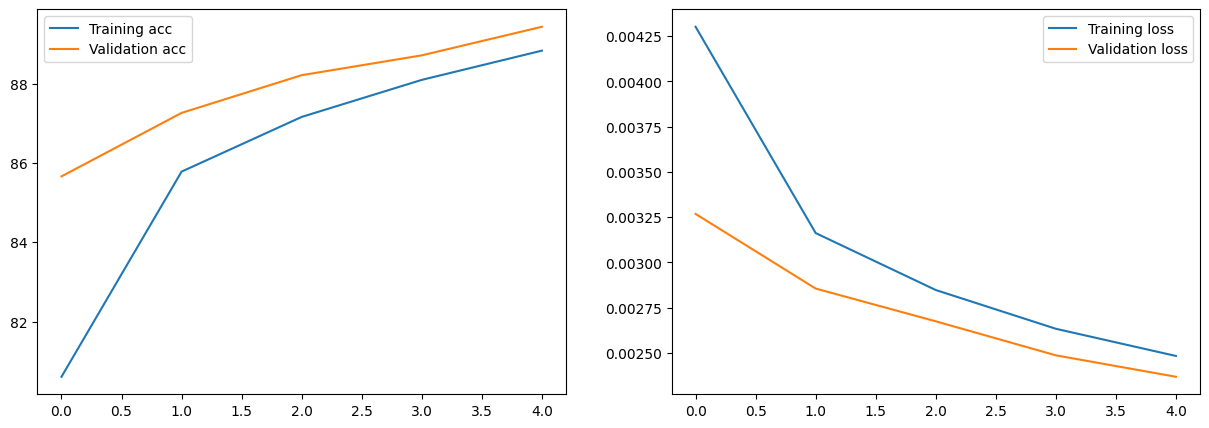

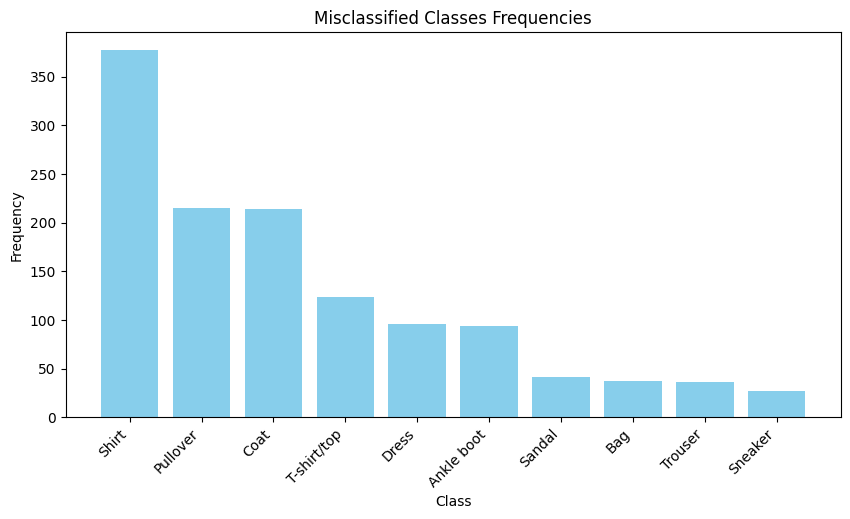

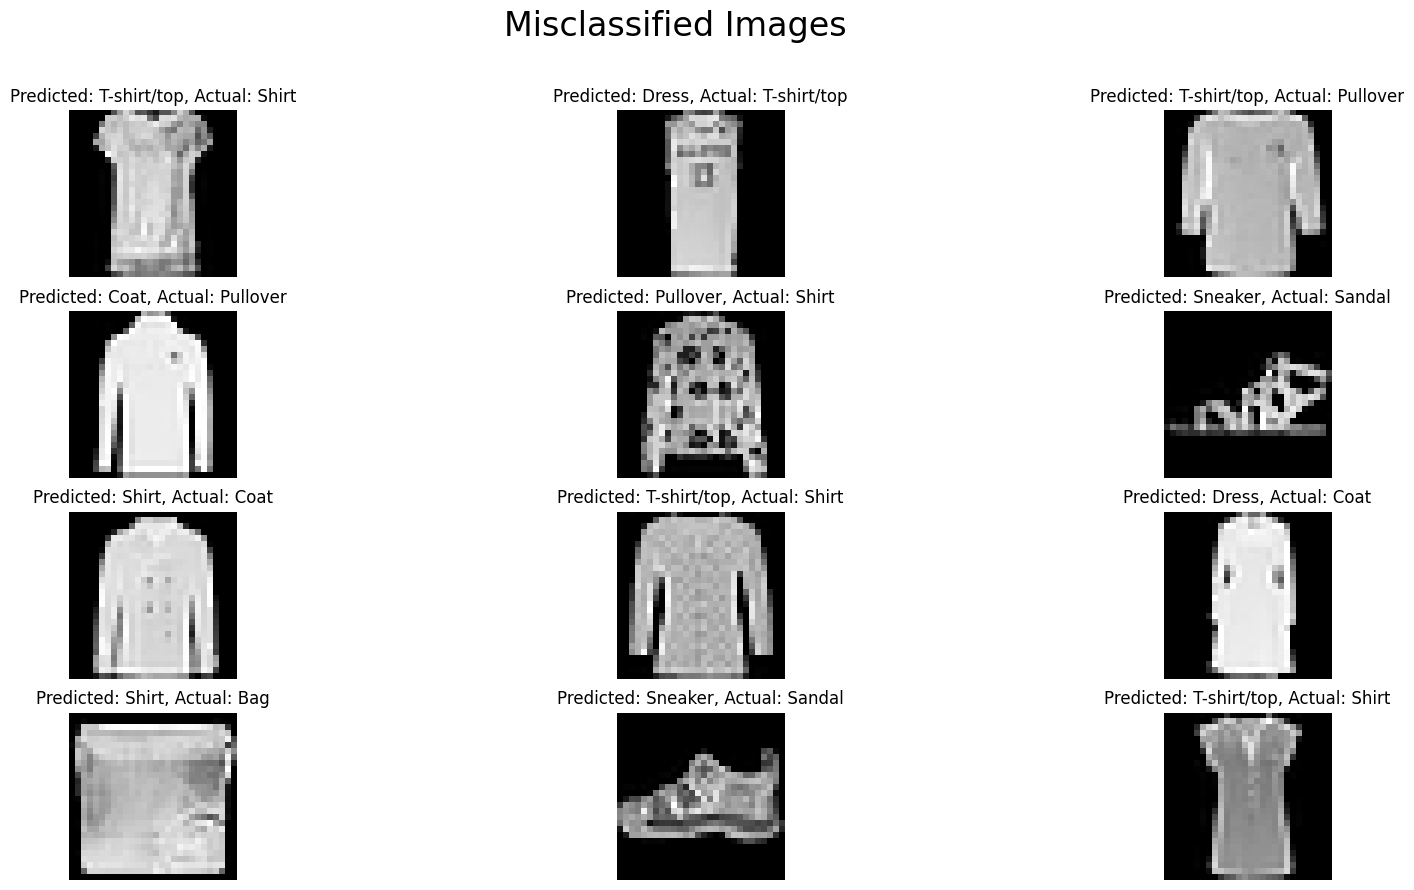

In [9]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 검증 데이터 로더 valid_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장.
hist = train(net,train_loader,valid_loader,epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음.
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할.

else: # 만약 hist가 None이 아니라 유효한 데이터가 있는 경우에 실행.
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌.
    hist_test = test(net, test_loader) # train된 모델을 테스트 데이터 로더 test_loader를 사용해 성능을 평가하고 평가 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장.
    